# Core preprocessing
## Combining the core images
All the hyperspectral images are already loaded in matlab to matlab datfiles and cut into 10cm intervals. The first step is to load the matlab files. 

In [2]:
%matplotlib inline

#load packages
from scipy.io import matlab
import os
import pandas as pd
import numpy as np
from PIL import Image
import joblib
from sklearn.cluster import KMeans
import scipy.ndimage
import math
from IPython.display import display
from matplotlib.pyplot import imshow

#get the list of files in the data folder
list_of_partial_cores = os.listdir('Data/Cores/10cm')
#initialize partial cores
partial_cores = list()

#read partial cores from matlab
for i in range(len(list_of_partial_cores)):
    dat = matlab.loadmat('Data/Cores/10cm/'+list_of_partial_cores[i])
    last_key = list(dat)[-1]
    dat = dat[last_key].astype('float32')
    partial_cores.append(dat)
## combine cores
#initialize vars
n_tot = 0
n_subs = 0
comb_cores = []

#loop through core names
for id in ref_all['coreId'].unique():
    #define the start
    i_start = n_tot
    #get number of sections
    n_subs = len(ref_all['coreId'][ref_all['coreId']==id])
    #define the start section for the next subcore
    n_tot = n_tot + n_subs
    #get dimensions for subcores
    dims2 = []
    dim1 = 0
    
    for i in range(i_start,n_tot):
        dims2.append(len(partial_cores[i][0]))
        dim1 = dim1+len(partial_cores[i])
        dim3 = len(partial_cores[i][0][0])
        
    #maximum width of core 
    dim2 = max(dims2)
    #initialize the core image
    comb_image = np.empty([dim1,dim2,dim3])
    #reset dim1
    dim1 = 0
    
    for i in range(i_start,n_tot):
        #load the subcore image
        img = partial_cores[i]
        #resize the subcore using the below loop to an empty array
        img_res = np.empty([len(partial_cores[i]),dim2,dim3])
        for idx in range(dim3):
            img_res[:,:,idx] = scipy.ndimage.zoom(img[:,:,idx], (1,dim2/len(partial_cores[i][0])),order=2)
        #copy that array to the initialized core image
        comb_image[dim1:dim1+len(partial_cores[i])][:][:] = img_res      
        #define the start pixel of next subcore
        dim1 = dim1+len(partial_cores[i])
        
    #append the image core to cores list
    comb_cores.append(comb_image)
    
#change the type to float32
for i in range(len(comb_cores)):
    comb_cores[i] = comb_cores[i].astype('float32')
    
#save the combined core dataset
joblib.dump(comb_cores,'Data/comb_cores.dat')
#test if the images are combined
im = Image.fromarray((comb_cores[1][:,:,150]-np.mean(comb_cores[1][:,:,150]))
                      /(np.std(comb_cores[1][:,:,150]))*255)
imshow(im)

['Data/comb_cores.dat']

In [22]:
#if everything works well, clear memory
%reset -f

## Removing background
Remove the background by knn unsupervised clustering for two clusters. It is important that images are ranged accross the spectra for each pixel to lessen the surface anomaly effects.

In [13]:
import numpy as np
import joblib 
from PIL import Image

#load the combined cores
comb_cores = joblib.load('Data/comb_cores.dat')
## Now for background removal
#define the kmeans unspupervised learner
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
#go through each item of the combine core dataset
comb_cores_wob = []

for i in range(len(comb_cores)):
    dat = comb_cores[i].copy()
    
    #normalize through the 3rd dimension
    for j in range(dat.shape[0]):
        for k in range(dat.shape[1]):
            dat[j,k,:] = (dat[j,k,:]-np.min(dat[j,k,:]))/(np.max(dat[j,k,:])-np.min(dat[j,k,:]))
            
    #kmeans
    dat_kmeans = (kmeans.fit(dat.reshape(-1,288)).labels_).reshape(dat.shape[0:2])
    #show the image to determine either 0 or 1 is background
    idx = dat_kmeans[0,0];
    dat[dat_kmeans==idx,:] = np.nan
    comb_cores_wob.append(dat)

#save cores without backgroundb
joblib.dump(comb_cores_wob,'Data/comb_cores_wob.dat')   

#check if the backgrounds are removed effectively
%matplotlib inline
im = Image.fromarray(comb_cores_wob[1][:,:,150]*255)
imshow(im)

['Data/comb_cores_wob.dat']

In [16]:
#free the memory if all is good
%reset -f

## Stiching the images
In order to stich core parts together, any row that has more than 50% nans will be deleted as these rows are most likely the gaps between the parts.

In [1]:
import numpy as np
import joblib 
from PIL import Image

comb_cores = joblib.load('Data/comb_cores.dat')
comb_cores_wob = joblib.load('Data/comb_cores_wob.dat')


comb_cores_wob_wonan = []
comb_cores_wonan = []

for i in range(len(comb_cores_wob)):
    idx_del = []
    dat = comb_cores_wob[i].copy()
    dat2 = comb_cores[i].copy()
    for j in range(len(dat)):
        #check if the row has more than 0.5 nans, delete it if it does
        if (np.count_nonzero(np.isnan(dat[j]))/(dat.shape[1]*dat.shape[2])>0.5):
            idx_del.append(j)
            
    dat = np.delete(dat,idx_del,0)
    dat2 = np.delete(dat2,idx_del,0)
    comb_cores_wob_wonan.append(dat)
    comb_cores_wonan.append(dat2)

joblib.dump(comb_cores_wob_wonan,'Data/comb_cores_wob_wonan.dat')
joblib.dump(comb_cores_wonan,'Data/comb_cores_wonan.dat')

['Data/comb_cores_wob_wonan.dat']

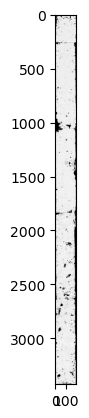

In [21]:
#check if the cores are stiched ok
%matplotlib inline
im = Image.fromarray(comb_cores_wob_wonan[1][:,:,150]*255)
imshow(im)

In [ ]:
#free the memory if all is good
%reset -f

## Getting the median of each 10cm and 1cm intervals for modelling

In [24]:
import joblib 
import numpy as np
import pandas as pd

#get the refs for all core in 10cm
ref_all = pd.read_csv('Soil_C_Data.csv',header=0)

#load refs for 15BE 1cm
ref_15BE = pd.read_csv('Soil_C_Data_BE15.csv',header=0)

comb_cores_wob_wonan = joblib.load('Data/comb_cores_wob_wonan.dat')

#get median of spectra for 10cm intervals for all cores
median_spectra = np.empty((len(ref_all),288))
p=0

for i in range(len(comb_cores_wob_wonan)):
    dat = comb_cores_wob_wonan[i].copy()
    n_subs = len(ref_all['coreId'][ref_all['coreId']==ref_all['coreId'].unique()[i]])
    
    for j in range(0,n_subs):
        start = math.floor(len(dat)*(j/n_subs))
        end = math.floor(len(dat)*((j+1)/n_subs))
        median_spectra[p,:] = np.nanmedian(dat[start:end,40:160,:],axis=(0,1))
        p = p + 1 

#save the 10cm spectra
joblib.dump(median_spectra,'Data/median_spectra.dat')
median_spectra=joblib.load('Data/median_spectra.dat')

#delete core 15BE from 10cm spectra and 10cm ref for validation purposes
median_spectra = np.delete(median_spectra,[list(range(9,18))],axis=0)
ref_all.drop(list(range(9,18)),axis=0,inplace=True)
ref_all.reset_index(inplace=True,drop=True)

#get 1cm spectra for core 15BE
median_spectra_15be = np.empty((len(ref_15BE),288))
p=0
dat = comb_cores_wob_wonan[1]
for i in range(len(median_spectra_15be)):
    start = math.floor(len(dat)*(i /len(median_spectra_15be)))
    end = math.floor(len(dat)*((i +1)/len(median_spectra_15be)))
    median_spectra_15be[p,:] = np.nanmedian(dat[start:end,40:160,:],axis=(0,1))
    p = p + 1 
    
joblib.dump(median_spectra_15be,'Data/median_spectra_15be.dat')
median_spectra_15be=joblib.load('Data/median_spectra_15be.dat')

#check if the spectra are saved correctly
%matplotlib inline
import seaborn as sns
sns.lineplot(median_spectra_15be[1,:])

In [27]:
#free the memory if all is good
%reset -f

# Model median of core sections to OC
In this section the medians from the core processing are to be modeled to reference OCs in 10cm intervals for 8 cores and tested on an additional core in 1cm intervals. First load the packages and data.

In [1]:
#load packages####################################################################################################################################
import os
import pandas as pd
import cv2
import numpy as np
from PIL import Image
import joblib
import scipy.ndimage
import math
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm
from mycolorpy import colorlist as mcp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score  
import seaborn as sns
import scipy 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import datasets, cluster
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl 
from sklearn.model_selection import cross_val_predict

#load the training setss
ref_all = pd.read_csv('Soil_C_Data.csv',header=0)
ref_all.drop(list(range(9,18)),axis=0,inplace=True)
ref_all.reset_index(inplace=True,drop=True)
y_train = ref_all['OC']
x_train=joblib.load('Data/median_spectra.dat')
wavel = pd.read_csv('wavelengths.csv')

x_train = np.delete(x_train,[list(range(9,18))],axis=0)
y_train.reset_index(inplace=True,drop=True)

#load the test sets
ref_15be= pd.read_csv('Soil_C_Data_BE15.csv',header=0)
y_test = ref_15be['OC']
x_test = joblib.load('Data/median_spectra_15be.dat')

comb_cores_wob_wonan = joblib.load('Data/comb_cores_wob_wonan.dat')

## Data exploration.
Explore the statistics and patterns in spectra and reference data.

C:\Users\shaya\AppData\Local\Temp\ipykernel_16256\116299922.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(['BE1','BE3','G1','G2','G3','P1','P2','P3'])
C:\Users\shaya\AppData\Local\Temp\ipykernel_16256\116299922.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['10cm OC','1cm OC on BE2'])


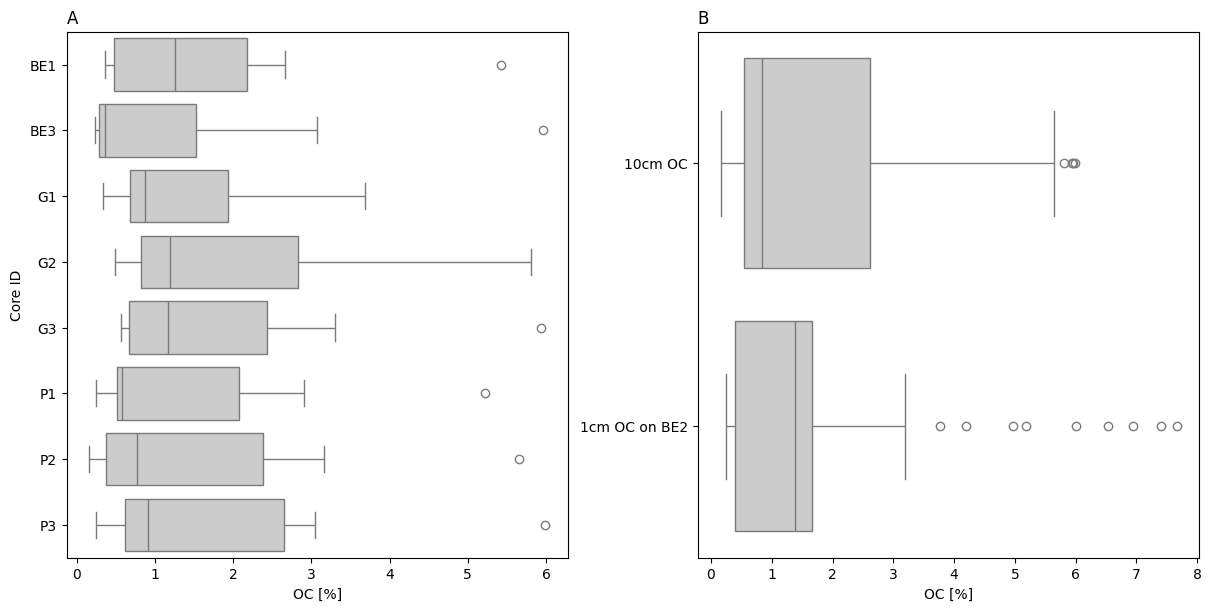

In [2]:
#boxplots for OC and cores
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6),layout="constrained")
sns.boxplot(x=ref_all['OC'],y=ref_all['coreId'],ax=ax1,color=".8")
ax1.set_ylabel('Core ID')
ax1.set_xlabel('OC [%]')
ax1.set_title('A',loc='left')
ax1.set_yticklabels(['BE1','BE3','G1','G2','G3','P1','P2','P3'])


#boxplots for OC and cores
tem_dat1 = pd.concat((ref_all['OC'],pd.Series(['10cm']*ref_all.shape[0],name='inter')),axis=1)
tem_dat2 = pd.concat((ref_15be['OC'],pd.Series(['1cm']*ref_15be.shape[0],name='inter')),axis=1)
tem_dat = pd.concat((tem_dat1,tem_dat2))

sns.boxplot(x=tem_dat['OC'],y=tem_dat['inter'],color=".8",ax=ax2)
ax2.set_ylabel('')
ax2.set_xlabel('OC [%]')
ax2.set_title('B',loc='left')
ax2.set_yticklabels(['10cm OC','1cm OC on BE2'])
plt.savefig('fig1.eps',dpi=300)
plt.show()


In [120]:
#Test if the 10cm training references and 1cm test references are from the same population
scipy.stats.ks_2samp(ref_all['OC'],ref_15be['OC']) 

KstestResult(statistic=0.15759147219821376, pvalue=0.22247890716866406, statistic_location=0.45, statistic_sign=-1)

Null hypothesis not rejected, the test and training set come from the same distribution

Check the correlation of each band with its kth step forwards.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0.99616774 0.95420925 0.80941137]


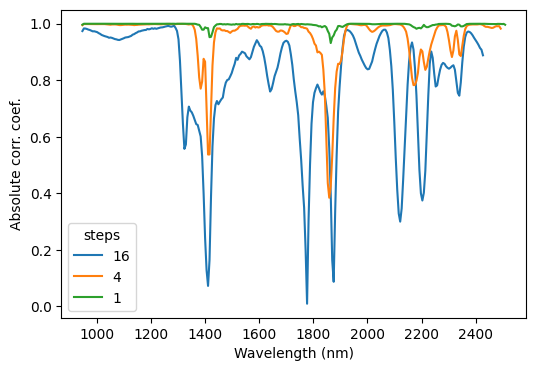

In [14]:
#check the correlations by step.
steps = [1,4,16]
corr_steps = np.zeros((3,288))
corr_steps[:,:] = np.nan
for i in range(3):
    for j in range((288-steps[i])):
        corr_steps[i,j] = np.abs(np.corrcoef(x_train[:,j],x_train[:,j+steps[i]])[0,1])
print(np.nanmean(corr_steps,axis=1))
corr_steps_frame = (corr_steps.reshape(-1))
corr_steps_frame = pd.DataFrame(corr_steps_frame)
corr_steps_frame = corr_steps_frame.iloc[::-1, ::-1]
corr_steps_frame['steps'] = np.concatenate((['16']*288,['4']*288,['1']*288))
fig, ax1 = plt.subplots(1,figsize=(6,4))
sns.lineplot(x=np.tile(wavel['x'][::-1].to_numpy(),3),y=corr_steps_frame.iloc[:,0], hue=corr_steps_frame['steps'],ax=ax1)
ax1.set_ylabel('Absolute corr. coef.')
ax1.set_xlabel('Wavelength (nm)')
plt.savefig('fig4.eps',dpi=300)
plt.show()

Plot the spectra of the training and test set for average of 10 bins against the correlation between each band and the SOC

C:\Users\shaya\AppData\Local\Temp\ipykernel_9364\265383795.py:17: RuntimeWarning: invalid value encountered in divide
  x_train_bins[:,i] = (np.histogram(x_train[:,i], bin, weights=x_train[:,i])[0] / np.histogram(x_train[:,i], bin)[0])
C:\Users\shaya\AppData\Local\Temp\ipykernel_9364\265383795.py:21: RuntimeWarning: invalid value encountered in divide
  x_test_bins[:,i] = (np.histogram(x_test[:,i], bin, weights=x_test[:,i])[0] / np.histogram(x_test[:,i], bin)[0])


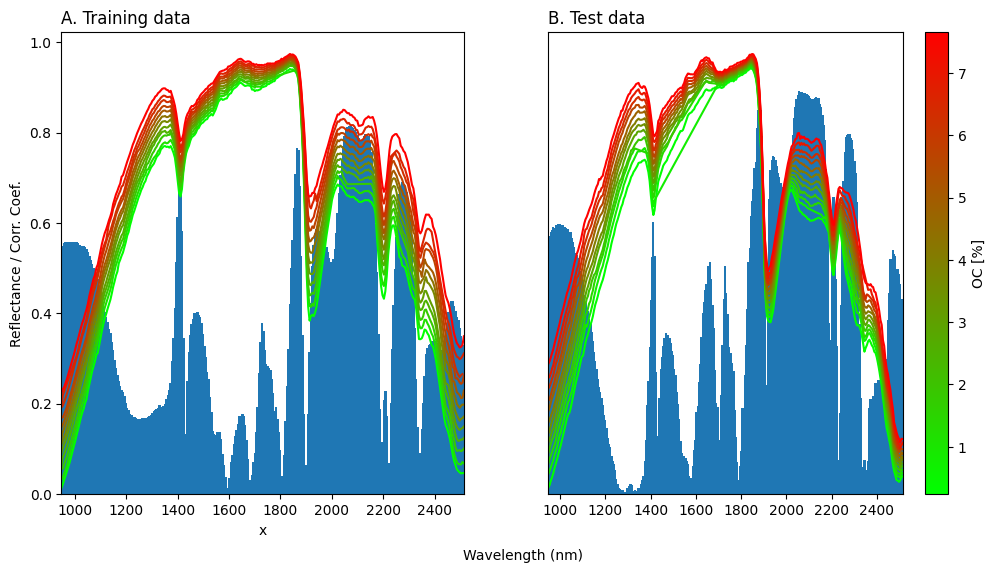

In [6]:
from sklearn.preprocessing import MinMaxScaler
bin = 12

color_array = []

corr_xtrain = pd.DataFrame(x_train).corrwith(y_train)
corr_xtest = pd.DataFrame(x_test).corrwith(y_test)

x_bars = MinMaxScaler(feature_range=(wavel['x'].min(),wavel['x'].max())).fit_transform((np.array(list(range(288)))).reshape(-1,1)).reshape(-1) 
x = np.log(ref_all['OC'])
ref_all_OC_bins = (np.histogram(x, bin, weights=x)[0] / np.histogram(x, bin)[0])
x = np.log(ref_15be['OC'])
ref_15be_OC_bins = (np.histogram(x, bin, weights=x)[0] / np.histogram(x, bin)[0])

x_train_bins = np.zeros((bin,288))
for i in range(x_train.shape[1]):
    x_train_bins[:,i] = (np.histogram(x_train[:,i], bin, weights=x_train[:,i])[0] / np.histogram(x_train[:,i], bin)[0])

x_test_bins = np.zeros((bin,288))
for i in range(x_test.shape[1]):
    x_test_bins[:,i] = (np.histogram(x_test[:,i], bin, weights=x_test[:,i])[0] / np.histogram(x_test[:,i], bin)[0])

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6),width_ratios=[1, 1.1])
#let's plot the spectra
x = ref_all_OC_bins
x = (x - x.min())/(x.max() - x.min())
for i in range(x_train_bins.shape[0]):
    sns.lineplot(y=x_train_bins[i],x=wavel['x'],ax=ax1,color=[x[i],1-x[i],0])
    #sns.lineplot(y=x_train_bins[i],x=range(288),ax=ax1,color=[x[i],1-x[i],0])
    color_array.append([x[i],1-x[i],0])

ax1.set_title('A. Training data',loc='left')
ax1.set_ylabel('Reflectance / Corr. Coef.')
ax1.bar(x=x_bars,height=abs(corr_xtrain),width=10,zorder=1)
ax1.set_xlim(wavel['x'].min(),wavel['x'].max())
x = ref_15be_OC_bins
x = (x - x.min())/(x.max() - x.min())

for i in range(x_test_bins.shape[0]):
    sns.lineplot(y=x_test_bins[i],x=wavel['x'],ax=ax2,color=[x[i],1-x[i],0])
    #sns.lineplot(y=x_test[i],x=range(288),ax=ax2,color=[x[i],1-x[i],0])

ax2.set_xlabel(' ')
fig.text(.46,0,'Wavelength (nm)')
ax2.set_yticklabels('')
ax2.set_yticks([])
ax2.bar(x=x_bars,height=abs(corr_xtest),width=10,zorder=1)
ax2.set_xlim(wavel['x'].min(),wavel['x'].max())
ax2.set_title('B. Test data',loc='left')

cdict = {'red':   [(0.0,  0.0, 0.0),
                   (1.0,  1.0, 1.0)],

         'green': [(0.0,  1.0, 1.0),
                   (1.0, 0.0, 0.0),
],

         'blue':  [(0.0,  0.0, 0.0),
                  (1.0,  0.0, 0.0)]}

cmapGR = LinearSegmentedColormap('GreenRed',cdict)
# create dummy invisible image
# (use the colormap you want to have on the colorbar)
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(y_test), np.max(y_test)), cmap=cmapGR),
             ax=ax2, orientation='vertical', label='OC [%]')
plt.savefig('fig2.eps',dpi=300)
plt.show()

Plot the PCAs for the spectra of the training set

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


95.2214801311318


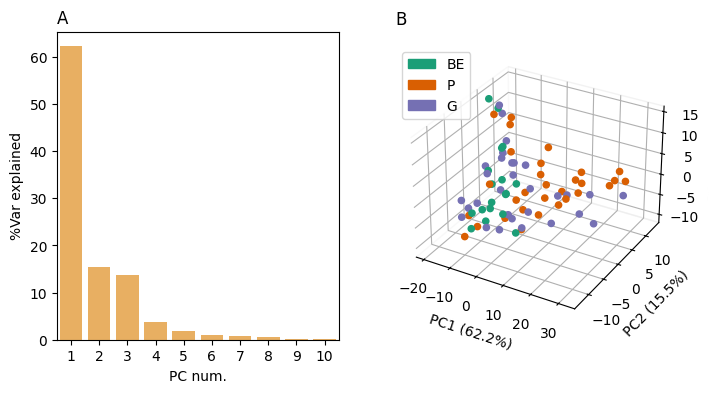

In [13]:
import warnings
warnings.filterwarnings('ignore')
#PCA for the Xtrain
#scale and perform PCA for core counts
pca = PCA()
scl = StandardScaler()
X_pca = scl.fit_transform(x_train)
X_pca = pca.fit_transform(X_pca)

#calculate explained variance
var = pca.explained_variance_
var = var/np.sum(var)*100
print(np.sum(var[0:4]))
#plot variance explaned and PC1,PC2 and PC3
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1)

sns.barplot(x=[1,2,3,4,5,6,7,8,9,10],y=var[0:10], color = (254/255,178/255,76/255,1),ax=ax1)
ax1.set_xlabel("PC num.")
ax1.set_ylabel("%Var explained")
ref_all['Soil type'] = 'type'
for i in range(len(ref_all)):
    if 'BE' in (ref_all['coreId'][i]):
        ref_all['Soil type'][i] = "BE"
    if 'G' in (ref_all['coreId'][i]):
        ref_all['Soil type'][i] = "G"   
    if 'P' in (ref_all['coreId'][i]):
        ref_all['Soil type'][i] = "P"


pal = ['#1b9e77', '#d95f02', '#7570b3']


colors = {'BE':pal[0], 'P':pal[1], 'G':pal[2]}
import matplotlib.patches as mpatches
patch1 = mpatches.Circle((0,0),1,color=pal[0], label='BE')
patch2 = mpatches.Circle((0,0),1,color=pal[1], label='P')
patch3 = mpatches.Circle((0,0),1,color=pal[2], label='G')

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2], c=ref_all['Soil type'].map(colors),alpha=1)
ax2.set_xlabel("PC1 (" + str(round(var[0],1))+"%)")
ax2.set_ylabel("PC2 (" + str(round(var[1],1))+"%)")
ax2.set_zlabel("PC3 (" + str(round(var[2],1))+"%)")
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False
handles, labels = ax2.get_legend_handles_labels()
handles.append(patch1)
handles.append(patch2) 
handles.append(patch3) 
ax2.margins(x=0,y=0)
ax1.set_title('A',loc='left')
ax2.set_title('B',loc='left',pad=15)



plt.legend(handles=handles, loc="upper left")
plt.savefig('fig3.eps',dpi=300,pad_inches=0.5,bbox_inches='')
plt.show()


## Modelling
Three regression models are used and tuned. PLSR, MPR and SVR. 

In [15]:
#load packages####################################################################################################################################
import os
import pandas as pd
import numpy as np
from PIL import Image
import joblib
import scipy.ndimage
import math
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm
from mycolorpy import colorlist as mcp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score  
import seaborn as sns
import scipy 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import datasets, cluster
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl 
from sklearn.model_selection import cross_val_predict


#load the training setss
ref_all = pd.read_csv('Soil_C_Data.csv',header=0)
ref_all.drop(list(range(9,18)),axis=0,inplace=True)
ref_all.reset_index(inplace=True,drop=True)
y_train = ref_all['OC']
x_train=joblib.load('Data/median_spectra.dat')
wavel = pd.read_csv('wavelengths.csv')

x_train = np.delete(x_train,[list(range(9,18))],axis=0)
y_train.reset_index(inplace=True,drop=True)

#load the test sets
ref_15be= pd.read_csv('Soil_C_Data_BE15.csv',header=0)
y_test = ref_15be['OC']
x_test = joblib.load('Data/median_spectra_15be.dat')

comb_cores_wob_wonan = joblib.load('Data/comb_cores_wob_wonan.dat')

## Regression for cores
results_cores = np.empty((3,4))
results_cores = pd.DataFrame(results_cores)
results_cores.columns = ['R2_val','RMSE_val','R2_test','RMSE_test']
results_cores.index = ['PLSR','MLPR','SVR']
results_pred_val = np.empty((y_train.shape[0],3))
results_pred_test  = np.empty((y_test.shape[0],3))
results_pred_val = pd.DataFrame(results_pred_val)
results_pred_test = pd.DataFrame(results_pred_test)
results_pred_val.columns = ['PLSR','MLPR','SVR']
results_pred_test.columns = ['PLSR','MLPR','SVR']
random.seed(0)
np.random.seed(0)

model_type = ['PLSR','MLPR']

for model_type in results_cores.index:
    #regression for model
    if model_type == 'PLSR':
        reg = Pipeline([('scl',StandardScaler()),('rg',PLSRegression())])
        #optimize for number of components
        param_grid = {
                'rg__n_components': range(1,200)}

        
    elif model_type == 'MLPR':

        reg = Pipeline([('agl',cluster.FeatureAgglomeration()),('scl',StandardScaler()),('rg',MLPRegressor(max_iter=1000,random_state=1))])
        
        #optimize for number of components
        param_grid = {
            'rg__activation': ['relu'],
            'rg__hidden_layer_sizes': [
                                    (100,100,100,100,100,100,100,100),
                                    (100,100,100,100,100,100,100,100,100),
                                    (100,100,100,100,100,100,100,100,100,100)
                    ],
            'rg__solver': ['lbfgs'],
            'rg__learning_rate_init':[1e-01,1e-02,1e-03],
            'agl__n_clusters':  [8,16,32,64,128]
        }
    elif model_type == 'SVR':
        reg = Pipeline([('agl',cluster.FeatureAgglomeration()),('scl',StandardScaler()),('rg',SVR())])
        #Optimize
        param_grid = {
            'rg__kernel': ['linear','poly','rbf','sigmoid'],
            'rg__coef0': [0,0.2,0.5,1],
            'rg__C': [1,2,3],
            'rg__epsilon': [0.1,0.2,0.3,0.4,0.5],
            'agl__n_clusters': [8,16,32,64,128]}

    search = GridSearchCV(reg, param_grid, cv=3,scoring={'R2':'r2','MSE':'neg_mean_squared_error'},refit='R2',n_jobs=-1,verbose=2)
    search.fit(x_train, y_train)

    if model_type=='MLPR':
        joblib.dump(search,'Data/MLPRmodel.dat')
        
    elif model_type=='PLSR':
        joblib.dump(search,'Data/PLSRmodel.dat')
        
    elif model_type=='SVR':
        joblib.dump(search,'Data/SVRmodel.dat')     
        
    #cross-validation results
    results_pred_val[model_type] = cross_val_predict(search.best_estimator_,x_train,y_train,cv=3)
    results_cores['RMSE_val'][model_type]=np.sqrt(np.nanmin(-search.cv_results_['mean_test_MSE']))
    results_cores['R2_val'][model_type]=search.best_score_

    #validation on core 15BE and 1cm intervals for gaussian process
    results_pred_test[model_type] = search.predict(x_test)
    results_cores['R2_test'][model_type]=r2_score(y_true=y_test,y_pred=search.predict(x_test))
    results_cores['RMSE_test'][model_type]=np.sqrt(mean_squared_error(y_true=y_test,y_pred=search.predict(x_test)))

results_cores.to_csv('cores_model_res.csv')
results_pred_val.to_csv('cores_val_predictions.csv')
results_pred_test.to_csv('test_predictions.csv')
print(results_cores)

Fitting 3 folds for each of 199 candidates, totalling 597 fits
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
        R2_val  RMSE_val   R2_test  RMSE_test
PLSR  0.921833  0.442762  0.812160   0.736260
MLPR  0.922842  0.434362  0.961426   0.333644
SVR   0.912610  0.470033  0.863620   0.627355


In [16]:
#let's see what is the best tuning for MLPR model
search = joblib.load('Data/MLPRmodel.dat')
print(search.best_params_)

search = joblib.load('Data/PLSRmodel.dat')
print(search.best_params_)

search = joblib.load('Data/SVRmodel.dat')
print(search.best_params_)

{'agl__n_clusters': 128, 'rg__activation': 'relu', 'rg__hidden_layer_sizes': (100, 100, 100, 100, 100, 100, 100, 100), 'rg__learning_rate_init': 0.1, 'rg__solver': 'lbfgs'}
{'rg__n_components': 7}
{'agl__n_clusters': 64, 'rg__C': 1, 'rg__coef0': 0, 'rg__epsilon': 0.1, 'rg__kernel': 'linear'}


Plot the predicted vs measured for test sets for the three models.

        R2_val  RMSE_val   R2_test  RMSE_test
PLSR  0.921833  0.442762  0.812160   0.736260
MLPR  0.922842  0.434362  0.961426   0.333644
SVR   0.912610  0.470033  0.863620   0.627355


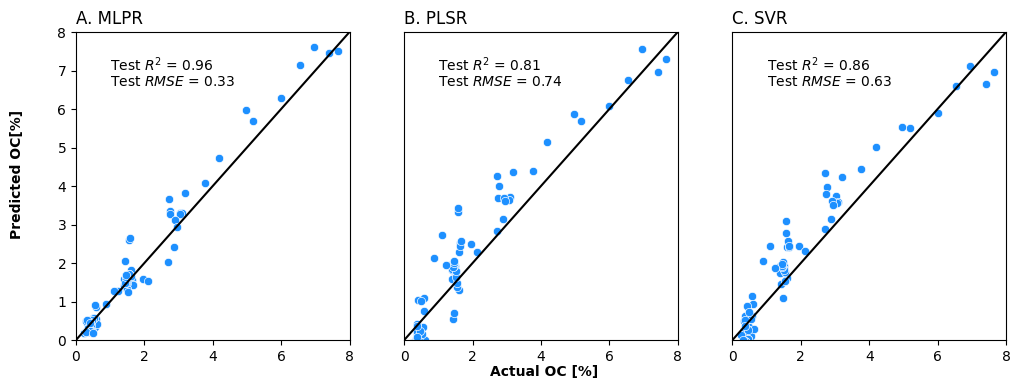

In [4]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import joblib
import scipy.ndimage
import math
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm
from mycolorpy import colorlist as mcp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score  
import seaborn as sns
import scipy 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import datasets, cluster
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl 
from sklearn.model_selection import cross_val_predict
#load the training setss
ref_all = pd.read_csv('Soil_C_Data.csv',header=0)
ref_all.drop(list(range(9,18)),axis=0,inplace=True)
ref_all.reset_index(inplace=True,drop=True)
y_train = ref_all['OC']
x_train=joblib.load('Data/median_spectra.dat')
wavel = pd.read_csv('wavelengths.csv')

x_train = np.delete(x_train,[list(range(9,18))],axis=0)
y_train.reset_index(inplace=True,drop=True)

#load the test sets
ref_15be= pd.read_csv('Soil_C_Data_BE15.csv',header=0)
y_test = ref_15be['OC']
x_test = joblib.load('Data/median_spectra_15be.dat')

comb_cores_wob_wonan = joblib.load('Data/comb_cores_wob_wonan.dat')
#plot the preds vs actuals for test sets
results_cores = pd.read_csv('cores_model_res.csv',index_col=0)
results_pred_val = pd.read_csv('cores_val_predictions.csv')
results_pred_test = pd.read_csv('test_predictions.csv')
print(results_cores)
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))
sns.scatterplot(y=results_pred_test['MLPR'].to_numpy().astype('float32'),x=y_test,ax=ax1,color='dodgerblue')
ax1.plot([0,8],[0,8],color='black')
ax1.set_title('A. MLPR',loc='left')
ax1.set_xlim(0,8)
ax1.set_ylim(0,8)
ax1.set_xlabel('')
ax1.text(1,7,"Test $R^2$ = "+ str(round(results_cores['R2_test']['MLPR'],2)))
ax1.text(1,6.6,"Test $RMSE$ = "+ str(round(results_cores['RMSE_test']['MLPR'],2)))
sns.scatterplot(y=results_pred_test['PLSR'].to_numpy().astype('float32'),x=y_test,ax=ax2,color='dodgerblue')
ax2.plot([0,8],[0,8],color='black')
ax2.set_title('B. PLSR',loc='left')
ax2.set_yticks([])
ax2.set_xlabel('')
ax2.set_xlim(0,8)
ax2.set_ylim(0,8)
ax2.text(1,7,"Test $R^2$ = "+ str(round(results_cores['R2_test']['PLSR'],2)))
ax2.text(1,6.6,"Test $RMSE$ = "+ str(round(results_cores['RMSE_test']['PLSR'],2)))
sns.scatterplot(y=results_pred_test['SVR'].to_numpy().astype('float32'),x=y_test,ax=ax3,color='dodgerblue')
ax3.plot([0,8],[0,8],color='black')
ax3.set_title('C. SVR',loc='left')
ax3.set_yticks([])
ax3.set_xlabel('')
ax3.set_xlim(0,8)
ax3.set_ylim(0,8)
ax3.text(1,7,"Test $R^2$ = "+ str(round(results_cores['R2_test']['SVR'],2)))
ax3.text(1,6.6,"Test $RMSE$ = "+ str(round(results_cores['RMSE_test']['SVR'],2)))
fig.text(0.47,0.02,'Actual OC [%]',weight='bold')
fig.text(0.07,0.37,'Predicted OC[%]',rotation = 90,weight='bold')
plt.savefig('fig5.eps',dpi=300,pad_inches=0.5,bbox_inches='')


Plot the predicted OC maps for three models and take the median of each row and plot it agains the actual OC for core BE2.

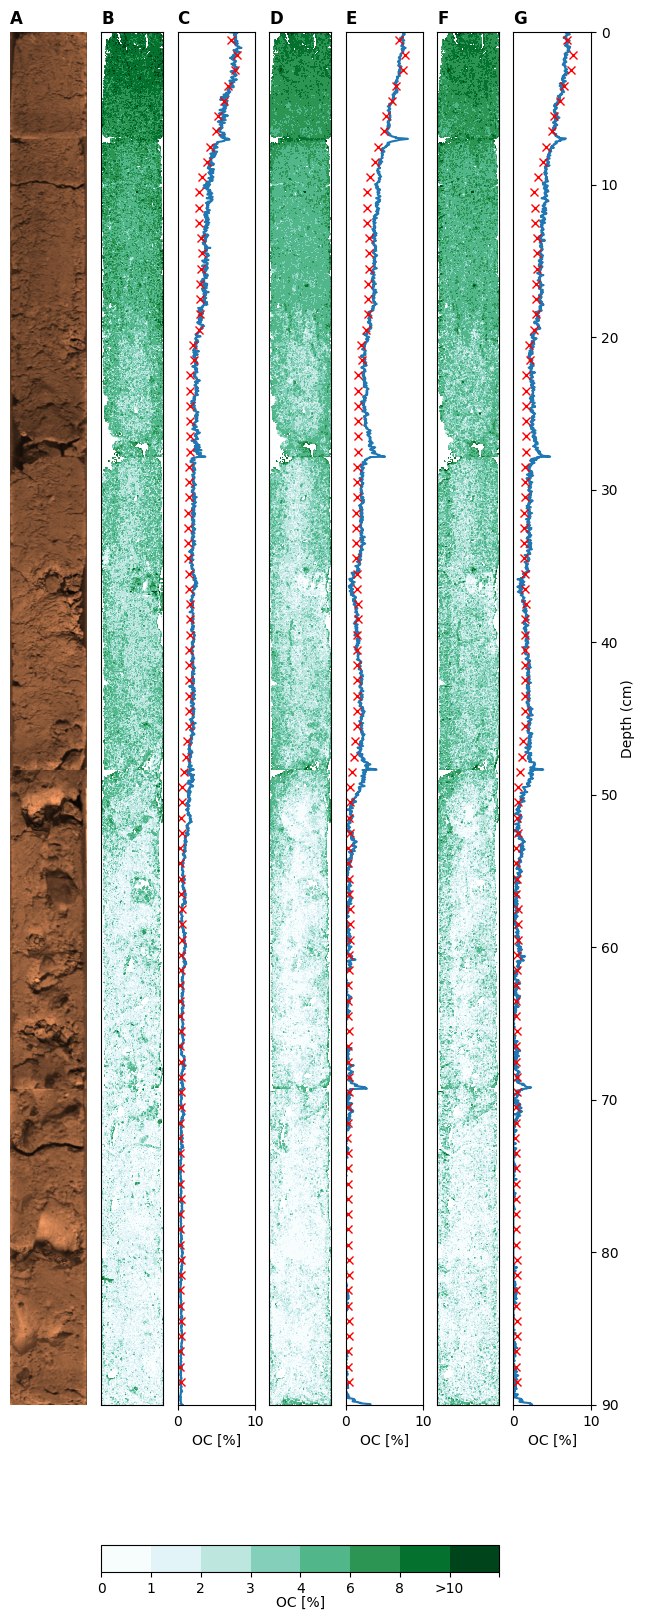

In [23]:
#plot the predicted map of SOC
%matplotlib inline

import warnings
import joblib
import numpy as np 
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl 
from mycolorpy import colorlist as mcp
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as gridspec
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#load the training setss
ref_all = pd.read_csv('Soil_C_Data.csv',header=0)
ref_all.drop(list(range(9,18)),axis=0,inplace=True)
ref_all.reset_index(inplace=True,drop=True)
y_train = ref_all['OC']
x_train=joblib.load('Data/median_spectra.dat')
wavel = pd.read_csv('wavelengths.csv')

x_train = np.delete(x_train,[list(range(9,18))],axis=0)
y_train.reset_index(inplace=True,drop=True)

#load the test sets
ref_15be= pd.read_csv('Soil_C_Data_BE15.csv',header=0)
y_test = ref_15be['OC']
x_test = joblib.load('Data/median_spectra_15be.dat')



warnings.filterwarnings('ignore')

model_type = ['MLPR','PLSR','SVR']
comb_cores_wob_wonan = joblib.load('Data/comb_cores_wob_wonan.dat')
counter = 1
labels = ['A','B','C','D','E','F','G']

scl = StandardScaler()

comb_cores_wonan = joblib.load('Data/comb_cores_wonan.dat')
r = comb_cores_wonan[1][:,:,120]

r = scl.fit_transform(r.reshape(-1, r.shape[-1])).reshape(r.shape)

img = r


gs = gridspec.GridSpec(2, 7,height_ratios=(50,1),width_ratios=(1,0.8,1,0.8,1,0.8,1))
plt.figure(figsize=(7.5,20),layout="constrained")

ax0 = plt.subplot(gs[0,0])
imgplot = ax0.imshow(img,cmap='copper')
ax0.axis('off')
ax0.set_title(labels[0], loc='left',weight='bold')

for model_type in model_type:   
    #load the ML model
    if model_type=='MLPR':
        search = joblib.load('Data/MLPRmodel.dat')
    elif model_type=='PLSR':
        search = joblib.load('Data/PLSRmodel.dat')
    elif model_type=='SVR':
        search = joblib.load('Data/SVRmodel.dat')
                                    
    #draw the predicted plot for MLPR
    #create the 15BE map
    dat = comb_cores_wob_wonan[1].copy()
    pred_map_15BE = np.empty((dat.shape[0:2]))
    pred_map_15BE[:,:] = np.nan
    for i in range(dat.shape[0]):
        for j in range(dat.shape[1]):
            if ~np.isnan(dat[i,j,:]).any():
                pred_map_15BE[i,j]= search.predict(dat[i,j,:].reshape(1,-1))

    pred_map_15BE[pred_map_15BE<=0]=0.0001
    # generate 2 2d grids for the x & y bounds
    x, y = np.meshgrid(np.linspace(0, 9, len(pred_map_15BE)), np.linspace(0, 7, len(pred_map_15BE[0])))
    levels = plt.MaxNLocator(nbins=10).tick_values(np.nanmin(pred_map_15BE), np.nanmax(pred_map_15BE))
    levels = [ 0.,  1.,  2.,  3.,  4., 6., 8., 10., 100.]

    cmap = plt.colormaps['BuGn']
    color1=mcp.gen_color(cmap="BuGn",n=8)

    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    
    ax1 = plt.subplot(gs[0,counter])
    c = ax1.contourf(y, x, np.transpose(pred_map_15BE), vmin=np.nanmin(pred_map_15BE), vmax=np.nanmax(pred_map_15BE),levels=levels,colors=color1)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title(labels[counter], loc='left',weight='bold')
    ax1.invert_yaxis()
    ax2 = plt.subplot(gs[0,counter+1]) # row 0, col 1
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.plot(np.nanmedian(pred_map_15BE,axis=1),np.linspace(0, 90, len(pred_map_15BE)))
    ax2.plot(ref_15be['OC'],ref_15be['length'],'rx')
    ax2.set_ylim(0,90)
    ax2.set_xlim(0,10)
    ax2.set_ylabel('Depth (cm)',labelpad = 2)
    ax2.set_xlabel('OC [%]')
    if counter != 5:
        ax2.set_yticks([])
        ax2.set_ylabel('')
    ax2.set_title(labels[counter+1], loc='left',weight='bold')
    counter = counter + 2
    ax2.invert_yaxis()

    ax3 = plt.subplot(gs[1, 1:6]) 
    cbar = plt.colorbar(c,cax=ax3,orientation='horizontal')
    cbar.set_ticklabels([ '0','1','2','3','4','6','8','>10',' '])
    cbar.set_label('OC [%]', rotation=0,labelpad=0)
    
plt.savefig('fig6.eps',dpi=300,pad_inches=0.5,bbox_inches='')
plt.show()
    

## Imputation importance for ML
In order to discover what are the importances for each wavelength each time a wavelength will be imputed and it will be calculated how much loss has occured. Steps of 16 are chosen for the permutation clusters.

In [25]:
#load packages####################################################################################################################################
import os
import pandas as pd
import cv2
import numpy as np
from PIL import Image
import joblib
import scipy.ndimage
import math
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm
from mycolorpy import colorlist as mcp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score  
import seaborn as sns
import scipy 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import datasets, cluster
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl 
from sklearn.model_selection import cross_val_predict
from random import shuffle 

#load the training setss
ref_all = pd.read_csv('Soil_C_Data.csv',header=0)
ref_all.drop(list(range(9,18)),axis=0,inplace=True)
ref_all.reset_index(inplace=True,drop=True)
y_train = ref_all['OC']
x_train=joblib.load('Data/median_spectra.dat')
wavel = pd.read_csv('wavelengths.csv')

x_train = np.delete(x_train,[list(range(9,18))],axis=0)
y_train.reset_index(inplace=True,drop=True)

#load the test sets
ref_15be= pd.read_csv('Soil_C_Data_BE15.csv',header=0)
y_test = ref_15be['OC']
x_test = joblib.load('Data/median_spectra_15be.dat')

#load model results 
results_cores = pd.read_csv('cores_model_res.csv',index_col=0)

#loss 
loss_cores = np.zeros((17,3))
loss_cores = pd.DataFrame(loss_cores)
loss_cores.columns = ['PLSR','MLPR','SVR']
model_type = ['PLSR','MLPR','SVR']


p = 0
for model_type in model_type:   
    #load the ML model
    if model_type=='MLPR':
        search = joblib.load('Data/MLPRmodel.dat')
    elif model_type=='PLSR':
        search = joblib.load('Data/PLSRmodel.dat')
    elif model_type=='SVR':
        search = joblib.load('Data/SVRmodel.dat')    
    #load the best model parameters
    best_model = search.best_estimator_
    loss = np.empty(17)
    corrs = np.empty(17)       
    for i in range(17):
        loss_step = np.empty(16)
        unpermuted = x_train[:,(i*16):((i+1)*16)].copy()
        corrs[i] = np.corrcoef(np.median(unpermuted,axis=1),y_train)[0,1]
        for j in range(16):
            x_train[:,(i*16):((i+1)*16)] = np.random.permutation(unpermuted)
            best_model.fit(x_train,y_train)
            loss_step[j] = (mean_squared_error(y_true=y_test,y_pred=best_model.predict(x_test))) - results_cores['RMSE_test'][model_type]**2
        loss[i] = np.mean(loss_step)
        x_train[:,(i*16):((i+1)*16)] = unpermuted.copy()
    loss_cores[model_type] = loss
    
loss_cores.to_csv('loss_res.csv')
np.savetxt("correlations.csv", corrs, delimiter=",")    


Plot the permutation importances for the three models and coefficients for the PLSR against the training set spectra.

SignificanceResult(statistic=0.11519607843137256, pvalue=0.659750043107423)
SignificanceResult(statistic=0.11519607843137256, pvalue=0.659750043107423)


C:\Users\shaya\AppData\Local\Temp\ipykernel_6308\1890159133.py:57: RuntimeWarning: invalid value encountered in divide
  x_train_bins[:,i] = (np.histogram(x_train[:,i], bin, weights=x_train[:,i])[0] / np.histogram(x_train[:,i], bin)[0])
C:\Users\shaya\AppData\Local\Temp\ipykernel_6308\1890159133.py:61: RuntimeWarning: invalid value encountered in divide
  x_test_bins[:,i] = (np.histogram(x_test[:,i], bin, weights=x_test[:,i])[0] / np.histogram(x_test[:,i], bin)[0])


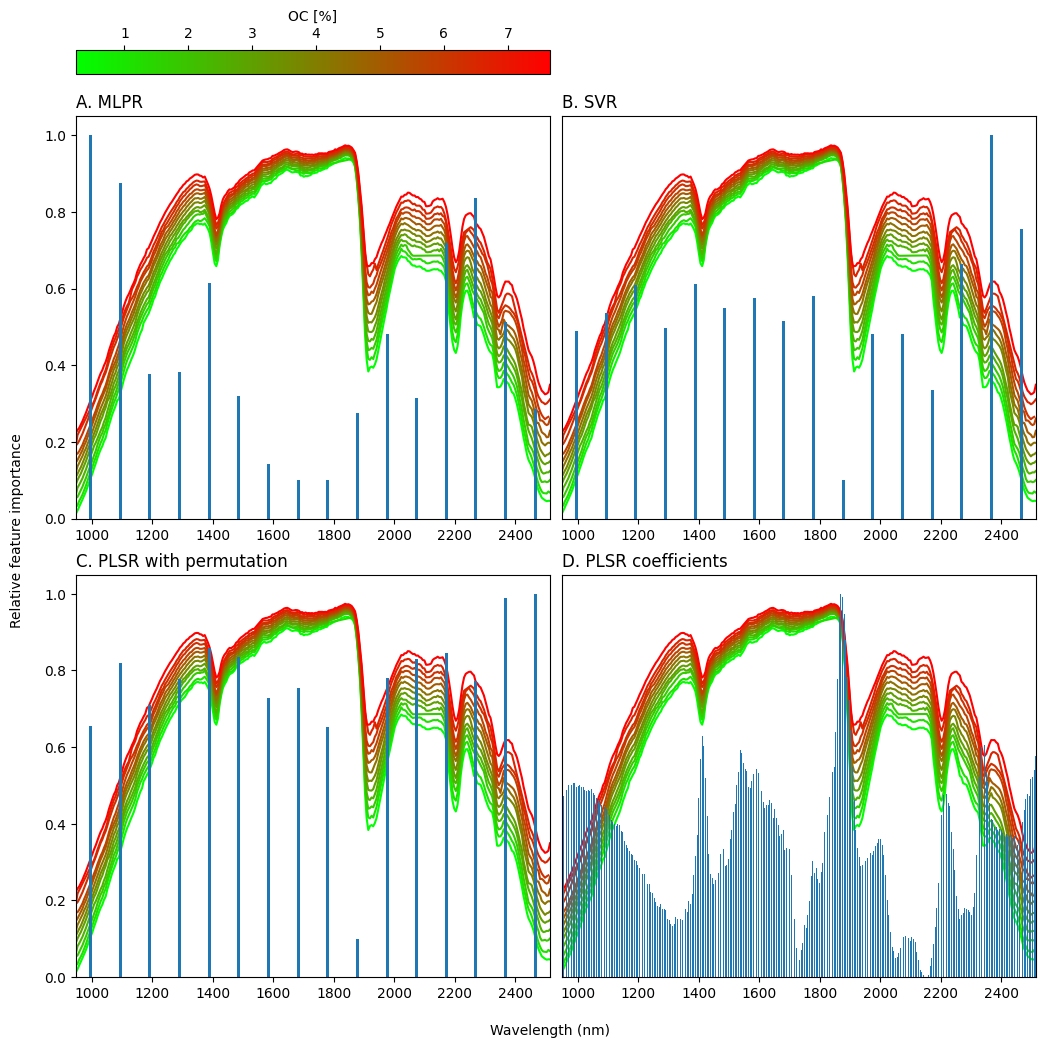

In [5]:
#plot the preds vs actuals for test sets
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr


#load the coefficients of PLSR
search = joblib.load('Data/PLSRmodel.dat')
best_model = search.best_estimator_
PLSR_coef = best_model['rg'].coef_[0]

#load the training setss
ref_all = pd.read_csv('Soil_C_Data.csv',header=0)
ref_all.drop(list(range(9,18)),axis=0,inplace=True)
ref_all.reset_index(inplace=True,drop=True)
y_train = ref_all['OC']
x_train=joblib.load('Data/median_spectra.dat')
wavel = pd.read_csv('wavelengths.csv')

x_train = np.delete(x_train,[list(range(9,18))],axis=0)
y_train.reset_index(inplace=True,drop=True)

#load the test sets
ref_15be= pd.read_csv('Soil_C_Data_BE15.csv',header=0)
y_test = ref_15be['OC']
x_test = joblib.load('Data/median_spectra_15be.dat')


loss_cores = pd.read_csv('loss_res.csv')
loss_cores.drop(loss_cores.columns[0],axis=1,inplace=True)
correls = pd.read_csv('correlations.csv',header=None)

print(spearmanr(correls.to_numpy().reshape(-1),loss_cores['MLPR'].to_numpy().reshape(-1)))
print(spearmanr(correls.to_numpy().reshape(-1),loss_cores['MLPR'].to_numpy().reshape(-1)))

wavel = pd.read_csv('wavelengths.csv')
bin = 12

ratio = wavel['x'].max()/288

x_bars = MinMaxScaler(feature_range=(wavel['x'].min(),wavel['x'].max())).fit_transform((np.array(list(range(17)))*16).reshape(-1,1)).reshape(-1) - ((wavel['x'].max() - wavel['x'].min())/32) 
color_array = []

x = np.log(ref_all['OC'])
ref_all_OC_bins = (np.histogram(x, bin, weights=x)[0] / np.histogram(x, bin)[0])
x = np.log(ref_15be['OC'])
ref_15be_OC_bins = (np.histogram(x, bin, weights=x)[0] / np.histogram(x, bin)[0])

x_train_bins = np.zeros((bin,288))
for i in range(x_train.shape[1]):
    x_train_bins[:,i] = (np.histogram(x_train[:,i], bin, weights=x_train[:,i])[0] / np.histogram(x_train[:,i], bin)[0])

x_test_bins = np.zeros((bin,288))
for i in range(x_test.shape[1]):
    x_test_bins[:,i] = (np.histogram(x_test[:,i], bin, weights=x_test[:,i])[0] / np.histogram(x_test[:,i], bin)[0])

fig, ((ax1, ax4), (ax2, ax3)) = plt.subplots(2,2,figsize=(10,10),layout='constrained')
#let's plot the spectra
x = ref_all_OC_bins
x = (x - x.min())/(x.max() - x.min())
for i in range(x_train_bins.shape[0]):
    sns.lineplot(y=x_train_bins[i],x=wavel['x'],ax=ax1,color=[x[i],1-x[i],0],zorder=0)
    #sns.lineplot(y=x_train_bins[i],x=range(288),ax=ax1,color=[x[i],1-x[i],0])
    color_array.append([x[i],1-x[i],0])
ax1.bar(x=x_bars,height=MinMaxScaler((0.1,1)).fit_transform(loss_cores['MLPR'].to_numpy().astype('float32').reshape(-1, 1)).reshape(-1),width=10,zorder=1)
#ax1.set_ylim(np.min(loss_cores.to_numpy()),np.max(loss_cores.to_numpy().max()))
ax1.set_title('A. MLPR',loc='left')
ax1.set_xlabel('')
ax1.set_xlim(wavel['x'].min(),wavel['x'].max())

x = ref_all_OC_bins
x = (x - x.min())/(x.max() - x.min())
for i in range(x_train_bins.shape[0]):
    sns.lineplot(y=x_train_bins[i],x=wavel['x'],ax=ax2,color=[x[i],1-x[i],0],zorder=0)
    #sns.lineplot(y=x_train_bins[i],x=range(288),ax=ax1,color=[x[i],1-x[i],0])
    color_array.append([x[i],1-x[i],0])  
ax2.bar(x=x_bars,height=MinMaxScaler((0.1,1)).fit_transform(loss_cores['PLSR'].to_numpy().astype('float32').reshape(-1, 1)).reshape(-1),width=10,zorder=1)
plt.plot([0,288],[0,0],color='black')
ax2.set_xlim(wavel['x'].min(),wavel['x'].max())
ax2.set_title('C. PLSR with permutation',loc='left')
ax2.set_xlabel('')

x = ref_all_OC_bins
x = (x - x.min())/(x.max() - x.min())
for i in range(x_train_bins.shape[0]):
    sns.lineplot(y=x_train_bins[i],x=wavel['x'],ax=ax3,color=[x[i],1-x[i],0],zorder=0)
    #sns.lineplot(y=x_train_bins[i],x=range(288),ax=ax1,color=[x[i],1-x[i],0])
    color_array.append([x[i],1-x[i],0])
cdict = {'red':   [(0.0,  0.0, 0.0),
                   (1.0,  1.0, 1.0)],

         'green': [(0.0,  1.0, 1.0),
                   (1.0, 0.0, 0.0),
],

         'blue':  [(0.0,  0.0, 0.0),
                  (1.0,  0.0, 0.0)]}

fig.text(0.45,-0.03,'Wavelength (nm)')
fig.text(-0.03,0.38,'Relative feature importance',rotation = 90)

cmapGR = LinearSegmentedColormap('GreenRed',cdict)
# create dummy invisible image
# (use the colormap you want to have on the colorbar)
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(y_test), np.max(y_test)), cmap=cmapGR),
             ax=ax1, orientation='horizontal', label='OC [%]',location='top')
ax3.bar(x=wavel['x'],height=MinMaxScaler().fit_transform(PLSR_coef.astype('float32').reshape(-1, 1)).reshape(-1),width=3,zorder=1)
ax3.set_title('D. PLSR coefficients',loc='left')
ax3.set_xlabel('')
plt.plot([0,288],[0,0],color='black')
ax3.set_xlim(wavel['x'].min(),wavel['x'].max())
ax3.set_yticks([])

x = ref_all_OC_bins
x = (x - x.min())/(x.max() - x.min())
for i in range(x_train_bins.shape[0]):
    sns.lineplot(y=x_train_bins[i],x=wavel['x'],ax=ax4,color=[x[i],1-x[i],0],zorder=0)
    #sns.lineplot(y=x_train_bins[i],x=range(288),ax=ax1,color=[x[i],1-x[i],0])
    color_array.append([x[i],1-x[i],0])
ax4.bar(x=x_bars,height=MinMaxScaler((0.1,1)).fit_transform(loss_cores['SVR'].to_numpy().astype('float32').reshape(-1, 1)).reshape(-1),width=10,zorder=1)
#ax1.set_ylim(np.min(loss_cores.to_numpy()),np.max(loss_cores.to_numpy().max()))
ax4.set_title('B. SVR',loc='left')
ax4.set_xlabel('')
ax4.set_xlim(wavel['x'].min(),wavel['x'].max())
ax4.set_yticks([])


    
plt.savefig('fig7.eps',dpi=300,pad_inches=0.5,bbox_inches='')


